##### Copyright 2019 The TensorFlow Authors.

In [3]:
!wget --no-check-certificate \
  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/8h65ywd2jr-2.zip\
  -O /tmp/data.zip

--2020-06-17 02:35:27--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/8h65ywd2jr-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.89.160
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.89.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3997547036 (3.7G) [application/octet-stream]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip       100%[===================>]   3.72G  35.9MB/s    in 70s     

2020-06-17 02:36:38 (54.4 MB/s) - ‘/tmp/data.zip’ saved [3997547036/3997547036]



In [7]:
import os
import zipfile
local_zip = '/tmp/data.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')

zip_ref.close()
local_zip = '/tmp/COVID-19 Dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')

zip_ref.close()

In [8]:
!rm -r /tmp/data.zip

# note
8yar asm el file bta3 el data le data

In [9]:
!mv /tmp/data/CT/COVID/* /tmp/data/X-ray/COVID
!mv /tmp/data/CT/Non-COVID/* /tmp/data/X-ray/Non-COVID
!rm -r /tmp/data/CT

In [10]:
base_dir = '/tmp/data/X-ray'

covid = os.path.join(base_dir, 'COVID')
non_covid = os.path.join(base_dir, 'Non-COVID')



In [11]:
train_covid_fnames = os.listdir( covid )
train_non_covid_fnames = os.listdir( non_covid )

print(len(train_covid_fnames))
print(len(train_non_covid_fnames))

9470
8128


In [14]:
from shutil import copyfile
import random

In [18]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


covid_SOURCE_DIR = "/tmp/data/COVID/"
TRAINING_covid_DIR = "/tmp/data/training/covid/"
TESTING_covid_DIR = "/tmp/data/test/covid/"
non_covid_SOURCE_DIR = "/tmp/data/Non-COVID/"
TRAINING_non_covid_DIR = "/tmp/data/training/non_covid/"
TESTING_non_covid_DIR = "/tmp/data/test/non_covid/"

split_size = .85
split_data(covid_SOURCE_DIR, TRAINING_covid_DIR, TESTING_covid_DIR, split_size)
split_data(non_covid_SOURCE_DIR, TRAINING_non_covid_DIR, TESTING_non_covid_DIR, split_size)

In [19]:
import tensorflow as tf

In [46]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('covs') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)      

In [48]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [23]:
!rm -rf /tmp/data/training/.ipynb_checkpoints
!rm -rf /tmp/data/test/.ipynb_checkpoints

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/data/training/"
train_datagen = ImageDataGenerator(rescale=1./255,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/data/test/"
validation_datagen = ImageDataGenerator(rescale=1./255,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 14949 images belonging to 2 classes.
Found 2638 images belonging to 2 classes.


In [38]:
validation_generator.class_indices

{'covid': 0, 'non_covid': 1}

In [42]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.980):
      print("\nReached 98.0% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks= myCallback()

In [49]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              verbose=1,
                              callbacks=[callbacks],
                              epochs=100)

Epoch 1/100
150/150 [==============================] - 164s 1s/step - loss: 0.5210 - accuracy: 0.7207 - val_loss: 0.3672 - val_accuracy: 0.8199
Epoch 2/100
150/150 [==============================] - 163s 1s/step - loss: 0.3502 - accuracy: 0.8392 - val_loss: 0.2835 - val_accuracy: 0.8779
Epoch 3/100
150/150 [==============================] - 163s 1s/step - loss: 0.2835 - accuracy: 0.8748 - val_loss: 0.2462 - val_accuracy: 0.8923
Epoch 4/100
150/150 [==============================] - 165s 1s/step - loss: 0.2409 - accuracy: 0.8986 - val_loss: 0.1757 - val_accuracy: 0.9280
Epoch 5/100
150/150 [==============================] - 166s 1s/step - loss: 0.2143 - accuracy: 0.9124 - val_loss: 0.1448 - val_accuracy: 0.9477
Epoch 6/100
150/150 [==============================] - 166s 1s/step - loss: 0.1869 - accuracy: 0.9242 - val_loss: 0.1480 - val_accuracy: 0.9439
Epoch 7/100
150/150 [==============================] - 165s 1s/step - loss: 0.1687 - accuracy: 0.9318 - val_loss: 0.1094 - val_accuracy:

In [50]:
model.save("/content")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/assets


In [56]:
import numpy as np
 
from google.colab import files
from keras.preprocessing import image
 
uploaded=files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + "   non_covid")
    
  else:
    print(fn + "   covid")

Saving 8a7486782d3933ccd9aefbce323169_jumbo.jpeg to 8a7486782d3933ccd9aefbce323169_jumbo.jpeg
[0.]
8a7486782d3933ccd9aefbce323169_jumbo.jpeg   covid


Text(0.5, 1.0, 'Training and validation loss')

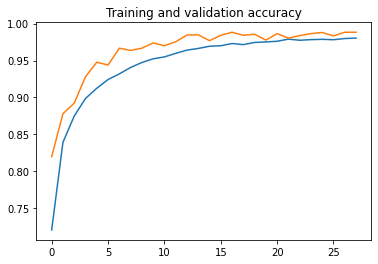

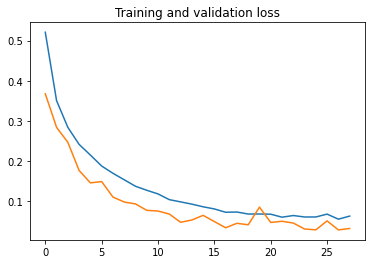

In [52]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
import matplotlib.pyplot as plt
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]
 
epochs   = range(len(acc)) # Get number of epochs
 
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()
 
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )